# Sequence+v1.0

**Goal**: Build a model that can predict the total run value for any given *two* pitch sequence<br>
**Author**: Jensen Holm <br>
**Date**: October / November 2024

In [1]:
%pip install git+https://github.com/Jensen-holm/statcast-era-pitches.git

  Cloning https://github.com/Jensen-holm/statcast-era-pitches.git to /private/var/folders/2_/kwjd2wv14q91l3mg7r83n04c0000gn/T/pip-req-build-i607tw54
  Running command git clone --filter=blob:none --quiet https://github.com/Jensen-holm/statcast-era-pitches.git /private/var/folders/2_/kwjd2wv14q91l3mg7r83n04c0000gn/T/pip-req-build-i607tw54
  Resolved https://github.com/Jensen-holm/statcast-era-pitches.git to commit 44138dfcd13fcc02df4054e34a7c581594b5ca8e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import statcast_pitches
import polars as pl
import numpy as np
from plotnine import *
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches)

In [3]:
# use statcast pitches to get all pitches thrown in since hawkeye began
pitches_lf: pl.LazyFrame = (statcast_pitches.load()
                            .filter(pl.col("game_date").dt.year() >= 2024))

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

print(f"N Pitches: {n_pitches}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 761176
Date Range: 2024-03-15 - 2024-10-30


In [4]:
run_values_24 = pl.scan_csv(
    # os.path.join(DATA_DIR, "run_values.csv")
    "https://raw.githubusercontent.com/Jensen-holm/Sequence-Plus/refs/heads/main/data/run_values.csv"
).rename({"event": "events"}) # it is called 'events' in pitches_df

# Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`|
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **3d_dist_0.167** | 3D euclidean distance between pitches in a two pitch sequence 0.167 seconds after release |
| **3d_dist_0.120** | 3D distance between pitches in a two pitch sequence at 0.120 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |
| **plate_x_diff** | difference in plate_x between pitches in a two pitch sequence |
| **plate_z_diff** | difference in plate_z between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

## Expected Run Value

Joining the expected runs from run_values_24 to the pitches dataframe so that each pitch has an associated run value.

**New Features**

- `delta_run_exp`

In [5]:

description_replace_mapping = {
    "Ball": "ball",
    "In play, run(s)": "hit_into_play",
    "In play, out(s)": "hit_into_play",
    "In play, no out": "hit_into_play",
    "Called Strike": "called_strike",
    "Foul": "foul",
    "Swinging Strike": "swinging_strike",
    "Blocked Ball": "ball",
    "Swinging Strike (Blocked)": "swinging_strike",
    "Foul Tip": "swinging_strike",
    "Foul Bunt": "foul",
    "Hit By Pitch": "hit_by_pitch",
    "Pitchout": "ball",
    "Missed Bunt": "swinging_strike",
    "Bunt Foul Tip": "swinging_strike",
    "Foul Pitchout": "foul",
    "Ball In Dirt": "ball",
}

def add_pitch_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_lf = lf.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_lf.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_lf = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_lf

pitches_run_value_lf = pitches_lf.pipe(add_pitch_run_value)
pitches_run_value_lf.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""747483""","""761176""",761176.0,761176.0,725703.0
"""null_count""","""13693""","""0""",0.0,0.0,35473.0
"""mean""",null,null,0.867148,0.901089,0.000023
"""std""",null,null,0.965891,0.829563,0.239968
"""min""","""CH""","""ball""",0.0,0.0,-1.463
"""25%""",null,null,0.0,0.0,-0.067
"""50%""",null,null,1.0,1.0,-0.016
"""75%""",null,null,1.0,2.0,0.035
"""max""","""SV""","""swinging_strike_blocked""",4.0,2.0,3.525


In order to keep it simple, I am mirroring the movement and the horizontal release position of each pitch thrown from LHP, to as if it were thrown by RHP.

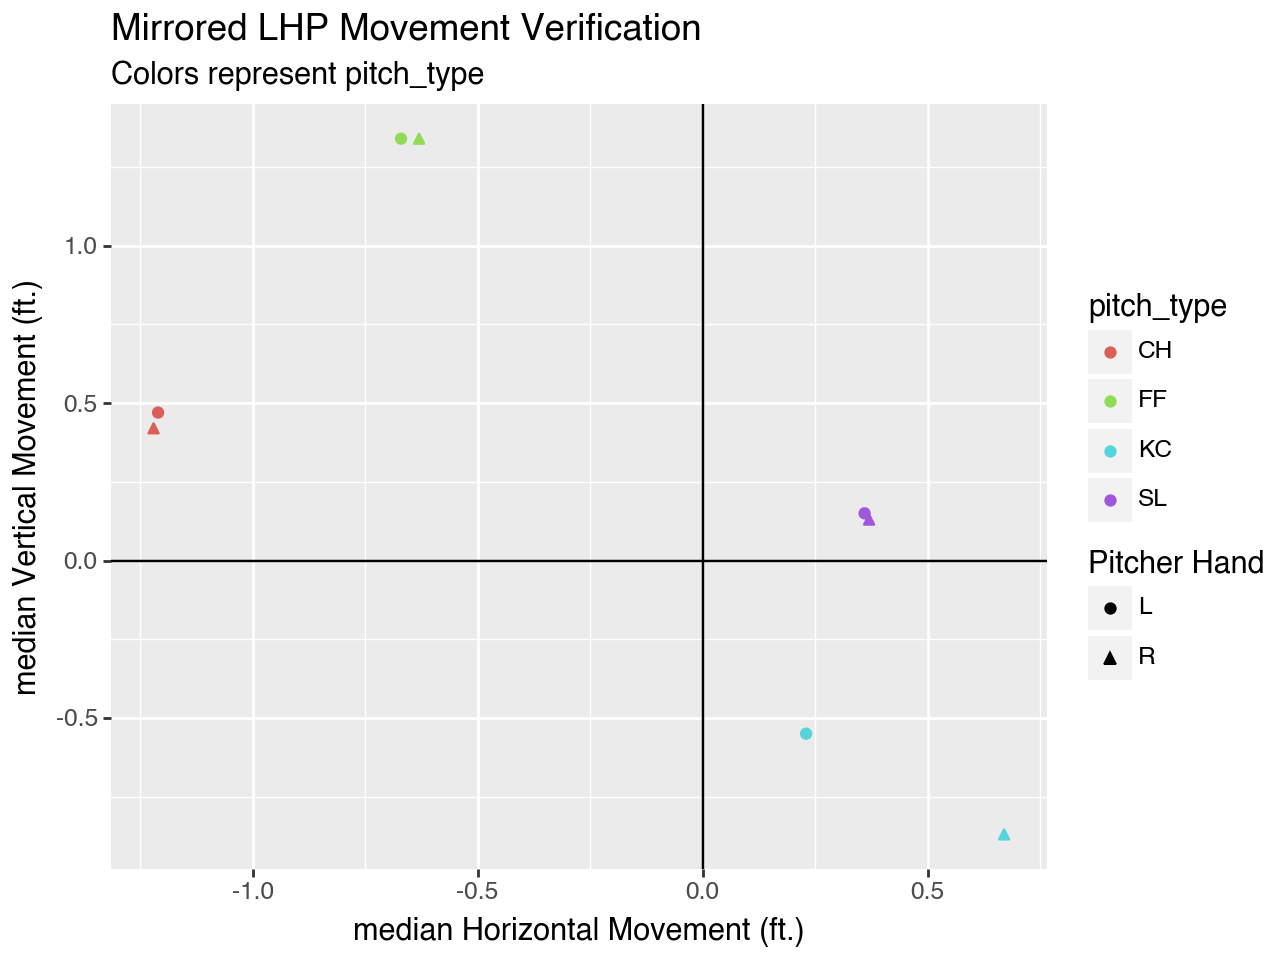

In [6]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),

        # also mirror the horizontal release point
        # (release_pos_x is from catcher perspective)
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("release_pos_x"))
        .otherwise(pl.col("release_pos_x")),
    )

mirrored_pitches_lf = pitches_run_value_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").median().alias("median_pfx_x"),
            pl.col("pfx_z").median().alias("median_pfx_z"),
        ).collect(),
        aes(x="median_pfx_x", y="median_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="median Horizontal Movement (ft.)",
        y="median Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Location Estimation

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

### Step 1: Time to 50ft. from home plate

Estimate the time it took the baseball to travel from release point to 50ft from home plate (the point where we have measurements for a &v in x, y, z dimensions)

$t_{50} = \frac{(60 + 6/12) - 50 - extension}{vft * 1.05}$

Where ...
- $extension = $ distance from the rubber where the pitch was released<br>
- $vft = $ release_speed in ft/s

I multiply the velocity by 1.05 in order to dialate the time by 5%. This makes our estimation of position more accurate because it helps account for error that we get from assuming that acceleration is constant in the kinematic equations for displacement.

**New Features**
- `t50`: estimated time it took the ball to get to 50ft. from home plate
- `release_pos_y`: release position in the y dimension converted to feet


In [7]:
def displacement(p0, v0, t, a):
    return p0 + v0 * t + 0.5 * a * t**2

def convert_release_y_to_ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(pl.col("release_pos_y") / 12)

def estimate_time_to_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        ((((60 + 6/12) - 50) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t50")
    )

time_to_50ft_lf = (mirrored_pitches_lf
                   .pipe(convert_release_y_to_ft)
                   .pipe(estimate_time_to_50ft))

(time_to_50ft_lf
    .select("release_pos_y", "t50")
    .describe())

statistic,release_pos_y,t50
str,f64,f64
"""count""",746281.0,745450.0
"""null_count""",14895.0,15726.0
"""mean""",4.50379,0.029637
"""std""",0.038004,0.004399
"""min""",4.313333,0.012265
"""25%""",4.48,0.026799
"""50%""",4.5025,0.029316
"""75%""",4.528333,0.032118
"""max""",4.775833,0.136384


### Step 2: x, y, & z positions at 50ft. from home plate

For this I use the kinematic equations with the acceleration, velocity and now our time estimate, $t_{50}$, to calculate displacement in each dimension.

$d_{50} = r_{dim} + v_{dim} * t_{50} * \frac{1}{2} * a_{dim} * t_{50}^2$

Where ...
- $r_{dim} = $ release position in x, y or z dimension
- $v_{dim} = $ velocity at 50ft. from home plate in x, y or z dimension
- $a_{dim} = $ acceleration at 50ft. from home plate in x, y or z dimension
- $t_{50} = $ estimated time that it took to get to 50ft. from home plate from step 1

**New Features**
- `x50`: position in the x dimension when the ball is 50ft. from home plate
- `y50`: position in the y dimension when the ball is 50ft. from home plate
- `z50`: position in the z dimension when the ball is 50ft. from home plate


In [8]:
def estimate_pos_at_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"release_pos_{d}"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t50"),
        ).alias(f"{d}50")
        for d in ["x", "y", "z"]
    )

pos_at_50ft_lf = time_to_50ft_lf.pipe(estimate_pos_at_50ft)

(pos_at_50ft_lf
    .select("x50", "y50", "z50")
    .describe())

statistic,x50,y50,z50
str,f64,f64,f64
"""count""",745450.0,745450.0,745450.0
"""null_count""",15726.0,15726.0,15726.0
"""mean""",-1.841894,0.69484,5.641312
"""std""",0.750444,0.391589,0.491664
"""min""",-5.027341,-1.990811,1.036836
"""25%""",-2.304915,0.469149,5.381889
"""50%""",-1.799675,0.72818,5.67098
"""75%""",-1.314786,0.915064,5.945786
"""max""",1.349322,2.622332,9.137442


### Step 3: Estimate 3D positions at commit time & decision time

Now we can make an estimate of where the ball is in all dimensions, at any given time. But I am interested specifically in 0.120 seconds after release (commit time), and 0.167 seconds after release (decision time).

For this I use the same formula that I used to esimate position at 50ft. from home plate, except I start from that 50ft. mark by calculating the difference in time between $t_{50}$ and $t_{i}$.

$d_{i} = p_{50} + v_{50} * (t_{50} - t_{i}) * \frac{1}{2} * a_{50} * (t_{50} - t_{i})^2$

Where ...
- $p_{50} = $ position in x, y, or z dimension at 50 ft. from home plate

I am assuming that both $v$ and $a$ are constant, again using a 5% time dilation as a crutch to help account for this.

**New Features**
- `x_0.120`: position in the x dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the y dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the z dimension at 0.120 seconds after release (commit time)
- `x_0.167`: position in the x dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the y dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the z dimension at 0.120 seconds after release (decision time)
- `t_plate`: estimated time that it takes the ball to reach home plate
- `x_plate`: position in the x dimension when the ball crossed the plate
- `y_plate`: position in the y dimension when the ball crossed the plate
- `z_plate`: position in the z dimension when the ball crossed the plate


In [9]:
def estimate_time_to_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        (((60 + 6/12) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t_plate")
    )

def estimate_ball_pos_at_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t_plate") - pl.col("t50"),
        ).alias(f"{d}_plate")
        for d in ["x", "y", "z"]
    )

def estimate_ball_pos_at_t(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=t - pl.col("t50"),
        ).alias(f"{d}_{t:.3f}")
        for d in ["x", "y", "z"]
        for t in times
    )

TIMES = [0.120, 0.167]

ball_pos_lf = (pos_at_50ft_lf
               .pipe(estimate_time_to_plate)
               .pipe(estimate_ball_pos_at_plate)
               .pipe(estimate_ball_pos_at_t, TIMES))

(ball_pos_lf
    .select("t50", "x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate")
    .describe())

statistic,t50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,x_plate,y_plate,z_plate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0
"""null_count""",15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0
"""mean""",0.029637,-1.627299,-10.936196,5.204777,-1.523965,-16.886659,4.901972,-1.080414,-44.741142,2.635362
"""std""",0.004399,0.983568,1.025537,0.472491,1.155276,1.411775,0.507478,2.051601,0.437697,0.885576
"""min""",0.012265,-6.60534,-13.681389,1.381013,-7.414727,-20.63631,1.431101,-11.012415,-57.228537,-6.206166
"""25%""",0.026799,-2.063213,-11.759901,4.910474,-1.958383,-18.021553,4.570639,-1.797597,-45.020221,2.05403
"""50%""",0.029316,-1.420893,-11.088943,5.197198,-1.215323,-17.098705,4.883972,-0.393946,-44.734685,2.636855
"""75%""",0.032118,-0.953703,-10.206092,5.497094,-0.744161,-15.88191,5.215215,0.284999,-44.456599,3.219887
"""max""",0.136384,1.694922,-0.481725,8.93593,1.940703,-2.532972,9.571308,8.951553,-39.457035,12.055414


### Pitch Location Visualization

In order to make sure this is working, here I make a 3D scatter plot of 3 random pitches thrown by Yu Darvish in the 2024 season and their estimated positions at release, 50ft from home, commit time, decision time, and across the plate.

**Plot Line Color Legend**
- `Sweeper`: Purple
- `Splitter`: Yellow
- `Slider`: Green
- `Knuckle Curve`: Blue
- `Four Seam Fastball`: Red


In [10]:
pitch_types = ["KC", "FF", "FS", "SL", "ST"]
cols = ["pitch_type", "release_pos_x", "release_pos_y", "release_pos_z",
        "x50", "y50", "z50", "x_0.120", "y_0.120", "z_0.120",
        "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate"]

extra_times = np.arange(0, 0.5, 0.05).tolist()
extra_time_cols = [f"{d}_{t:.3f}"
                   for d in ["x", "y", "z"]
                   for t in extra_times]

# for the visualization, I am going to use a lot more time intervals
# for position estimation to get a smoother curve
sample_pitch_df = (ball_pos_lf
                   .filter(pl.col("game_date").dt.year() == 2024)
                   .filter(pl.col("pitch_type").is_in(pitch_types))
                   .filter(pl.col("player_name") == "Darvish, Yu")
                   .pipe(estimate_ball_pos_at_t, extra_times)
                   .drop_nulls(cols + extra_time_cols)
                   .group_by("pitch_type")
                   .agg(pl.col("*").sample(1, seed=40))
                   .select(cols + extra_time_cols)
                   .explode([pl.col(col)
                             for col in (cols + extra_time_cols)
                             if col != "pitch_type"])
                   .collect())


fig = px.scatter_3d()
colors = {"KC": "blue", "FF": "red", "FS": "yellow", "SL": "green", "ST": "purple"}
for pitch in sample_pitch_df.iter_rows(named=True):
    pitch_fig = px.line_3d(
        x=[pitch["release_pos_x"]] + [pitch[f"x_{t:.3f}"] for t in extra_times],
        y=[pitch["release_pos_y"]] + [pitch[f"y_{t:.3f}"] for t in extra_times],
        z=[pitch["release_pos_z"]] + [pitch[f"z_{t:.3f}"] for t in extra_times],
    )

    pitch_fig.update_traces(line=dict(color=colors[pitch["pitch_type"]]))
    fig.add_traces(pitch_fig.data)

fig.update_layout(title=dict(text="Random Yu Darvish Pitch Location Estimation"), showlegend=True)
fig.show()

## Location Estimation Error

Since I have the ground truth for release position, I can measure roughly how accurate the position estimation functions are by trying to estimate this release position in 3D space. I compute the mean euclidean distance between estimated release position and actual release position.

$3Deuclideandistance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

Looking at the results, depending on the pitch type, it is typically off by anywhere between .4 inches and .8 inches on average.

**New Features**
- `approx_release_pos_x`: approximated release position in the x dimension working back from 50ft.
- `approx_release_pos_y`: approximated release position in the y dimension working back from 50ft.
- `approx_release_pos_z`: approximated release position in the z dimension working back from 50ft.


In [11]:
def estimate_release_pos(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=-pl.col("t50"),
        ).alias(f"approx_release_pos_{d}")
        for d in ["x", "y", "z"]
    )

ball_pos_lf = ball_pos_lf.pipe(estimate_release_pos)


def euclidean_distance(*pts):
    return sum((pt[0] - pt[1]) ** 2 for pt in pts) ** 0.5


(ball_pos_lf
    .drop_nulls([col for col in ball_pos_lf.collect_schema().names() if "release" in col])
    .select("release_pos_x", "release_pos_y", "release_pos_z",
            "approx_release_pos_x", "approx_release_pos_y", "approx_release_pos_z",
            "pitch_type")
    .filter(pl.col("pitch_type").is_in(pitch_types))
    .group_by("pitch_type")
    .agg(
        (euclidean_distance(
            *[(pl.col(f"approx_release_pos_{d}"), pl.col(f"release_pos_{d}"))
            for d in ["x", "y", "z"]]
        ).mean() * 12).alias("mean_euclidean_error_in.")
    )
    .collect())

pitch_type,mean_euclidean_error_in.
str,f64
"""FS""",0.438919
"""SL""",0.458928
"""FF""",0.323073
"""KC""",0.591464
"""ST""",0.527257


## Sequence Features

**New Feautres**

Everything in the `prev_features` list will be added, I don't want to type all of that out.

**Note**

May or may not need this depending on what sort of model I end up building

In [12]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_x_0.120",
    "prev_y_0.120",
    "prev_z_0.120",
    "prev_x_0.167",
    "prev_y_0.167",
    "prev_z_0.167",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_x_plate",
    "prev_y_plate",
    "prev_z_plate",
    "prev_pitch_type",
]

def two_pitch_sequences(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=[True] * len(sort_cols),
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            for feature in [f.replace("prev_", "") for f in seq_features]
        ])
        .select(*sort_cols + seq_features)
        .join(other=lf, on=sort_cols, how="right")
    )

sequence_pitches_lf = (ball_pos_lf
                       .pipe(two_pitch_sequences, prev_features))

(sequence_pitches_lf
    .select(prev_features)
    .describe())

statistic,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,prev_z_0.120,prev_x_0.167,prev_y_0.167,prev_z_0.167,prev_release_pos_x,prev_release_pos_y,prev_release_pos_z,prev_release_speed,prev_effective_speed,prev_release_spin_rate,prev_delta_run_exp,prev_x_plate,prev_y_plate,prev_z_plate,prev_pitch_type
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",719505.0,719505.0,718670.0,718670.0,718670.0,718670.0,718670.0,718670.0,719505.0,719505.0,719505.0,719504.0,718394.0,716174.0,700583.0,718670.0,718670.0,718670.0,"""720621"""
"""null_count""",54371.0,54371.0,55206.0,55206.0,55206.0,55206.0,55206.0,55206.0,54371.0,54371.0,54371.0,54372.0,55482.0,57702.0,73293.0,55206.0,55206.0,55206.0,"""53255"""
"""mean""",-0.32298,0.587488,-1.625712,-10.940308,5.20347,-1.521916,-16.892136,4.900503,-1.909632,4.50363,5.757664,89.194393,89.453109,2260.00459,-0.001664,-1.074505,-44.736599,2.634385,null
"""std""",0.844157,0.711332,0.98577,1.02054,0.474191,1.157832,1.405036,0.509534,0.737582,0.037804,0.529617,5.952991,6.108701,362.574929,0.217474,2.056139,0.436359,0.894769,null
"""min""",-2.25,-2.45,-6.60534,-13.681389,1.381013,-7.414727,-20.617553,1.431101,-4.73,4.313333,0.78,32.3,30.0,9.0,-1.463,-11.012415,-57.228537,-6.206166,"""CH"""
"""25%""",-1.04,0.13,-2.061859,-11.764303,4.908474,-1.955111,-18.027337,4.567328,-2.39,4.479167,5.49,84.9,85.1,2107.0,-0.061,-1.779728,-45.016126,2.04301,null
"""50%""",-0.49,0.63,-1.418204,-11.094124,5.196363,-1.212666,-17.105208,4.883152,-1.88,4.5025,5.8,90.1,90.4,2291.0,-0.016,-0.393239,-44.73118,2.635908,null
"""75%""",0.33,1.2,-0.950297,-10.208015,5.498012,-0.74134,-15.884456,5.216917,-1.39,4.528333,6.08,94.0,94.3,2470.0,0.034,0.295369,-44.452188,3.228116,null
"""max""",2.95,2.31,1.694922,-0.498532,8.93593,1.940703,-2.556452,9.571308,1.18,4.768333,8.05,105.1,107.1,3578.0,3.525,8.951553,-39.457035,12.055414,"""SV"""


## Adding 'diff' Features

**New Features**

For every feature in `prev_features`, we simply measure the difference in that feature between each pitch in a sequence. Each diff feature is its original name post fixed with 'diff'. Ex: `x_0.120_diff`, `y_0.120_diff` etc ...

In [13]:
def add_diff_features(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    return lf.with_columns(
        (pl.col(feature.replace("prev_", ""))
        - pl.col(feature)).alias(f"{feature.replace('prev_', '')}_diff")
        for feature in seq_features
        if feature != "prev_pitch_type"
    )

sequence_diff_pitches_lf = sequence_pitches_lf.pipe(add_diff_features, prev_features)

diff_features = [
    f"{feature.replace('prev_', '')}_diff"
    for feature in prev_features
    if feature != "prev_pitch_type"
    and feature != "delta_run_exp_diff"
]

(sequence_diff_pitches_lf
    .select(diff_features)
    .describe())

statistic,pfx_x_diff,pfx_z_diff,x_0.120_diff,y_0.120_diff,z_0.120_diff,x_0.167_diff,y_0.167_diff,z_0.167_diff,release_pos_x_diff,release_pos_y_diff,release_pos_z_diff,release_speed_diff,effective_speed_diff,release_spin_rate_diff,delta_run_exp_diff,x_plate_diff,y_plate_diff,z_plate_diff
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",719292.0,719292.0,718216.0,718216.0,718216.0,718216.0,718216.0,718216.0,719292.0,719292.0,719292.0,719290.0,717669.0,715065.0,700530.0,718216.0,718216.0,718216.0
"""null_count""",54584.0,54584.0,55660.0,55660.0,55660.0,55660.0,55660.0,55660.0,54584.0,54584.0,54584.0,54586.0,56207.0,58811.0,73346.0,55660.0,55660.0,55660.0
"""mean""",-0.001395,-0.002318,0.00087,-0.001463,-0.001715,0.000723,-0.002048,-0.001812,0.001232,-0.00001,-0.001758,0.007352,0.009398,-0.925466,0.001611,-0.000118,-0.001046,-0.002714
"""std""",1.063384,0.905873,0.408608,1.230314,0.413118,0.50811,1.695191,0.539469,0.215934,0.017145,0.15777,7.201021,7.30368,398.277452,0.322031,1.023022,0.272631,1.200048
"""min""",-4.1,-3.61,-3.485634,-10.759134,-3.887295,-3.866387,-14.847905,-4.24729,-2.96,-0.211667,-3.35,-50.5,-53.3,-2807.0,-3.564,-9.390767,-12.429186,-9.022921
"""25%""",-0.51,-0.44,-0.25571,-0.737199,-0.2622,-0.323741,-1.013926,-0.34436,-0.11,-0.009167,-0.08,-4.4,-4.3,-140.0,-0.099,-0.670319,-0.16435,-0.782799
"""50%""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",0.52,0.44,0.258206,0.741235,0.259527,0.3254,1.019839,0.34155,0.12,0.009167,0.08,4.3,4.3,141.0,0.086,0.670959,0.163748,0.773523
"""max""",4.29,3.67,3.341437,9.041928,3.502161,3.545338,12.493472,4.181905,2.8,0.255,2.8,60.6,63.1,2794.0,3.781,8.667766,11.138491,12.003925


## 3D distance features

Using the euclidean distance function from earlier, I can create features that represent the distance between a pitch, and the previous pitch thrown in any given two pitch sequence.

In [14]:
def add_3D_distances(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        # distance over the plate
        euclidean_distance(
            *[(pl.col(f"{d}_plate"), pl.col(f"prev_{d}_plate"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_plate"),

        # distance at release
        euclidean_distance(
            *[(pl.col(f"release_pos_{d}"), pl.col(f"prev_release_pos_{d}"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_release"),

        # distances at given times after release
        *[euclidean_distance(
            *[(pl.col(f"{d}_{t:.3f}"), pl.col(f"prev_{d}_{t:.3f}"))
             for d in ["x", "y", "z"]]
        ).alias(f"3d_dist_{t:.3f}")
        for t in times]
    )

sequence_dist_pitches_lf = sequence_diff_pitches_lf.pipe(add_3D_distances, TIMES)

(sequence_dist_pitches_lf
    .select("3d_dist_0.120", "3d_dist_0.167",
            "3d_dist_plate", "3d_dist_release")
    .describe())

statistic,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,3d_dist_release
str,f64,f64,f64,f64
"""count""",718216.0,718216.0,718216.0,719292.0
"""null_count""",55660.0,55660.0,55660.0,54584.0
"""mean""",1.122686,1.521045,1.395168,0.210029
"""std""",0.768687,1.053233,0.783919,0.166448
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.474485,0.631946,0.823798,0.09852
"""50%""",0.963878,1.294333,1.280892,0.170204
"""75%""",1.658248,2.25841,1.845021,0.2775
"""max""",11.017295,15.136046,13.018015,3.433369


# Serializing the LazyFrame w/ Features

This will allow me to pick up at this point in a new notebook if I want to

In [15]:
import os

DATA_DIR = os.path.join("..", "data")

sequence_dist_pitches_lf.serialize(
    os.path.join(DATA_DIR, "two_pitch_seqs_lf")
)

ball_pos_lf.serialize(
    os.path.join(DATA_DIR, "ball_pos_lf")
)

## Pre Processing

- Splitting data into training & test splits 
- Standard Scalar Normalization

In [ ]:
FEATURES = [
    "release_spin_rate",
    "release_speed",
    "3d_dist_release",
    "3d_dist_0.120",
    "3d_dist_0.167",
    "3d_dist_plate",
    "ax",
    "ay",
    "az",
    "vx0",
    "vy0",
    "vz0",
    "x50",
    "y50",
    "z50",
    "x_0.120",
    "y_0.120",
    "z_0.120",
    "x_0.167",
    "y_0.167",
    "z_0.167",
    "plate_x",
    "plate_z",
    "x_plate",
    "y_plate",
    "z_plate",
    "zone",
    "release_extension",
] + diff_features + prev_features

RESPONSE = "seq_delta_run_exp"

two_seqs_lf = (sequence_dist_pitches_lf
               .with_columns((pl.col("delta_run_exp") 
                              + pl.col("prev_delta_run_exp"))
                              .alias(RESPONSE))
               .select(*FEATURES, RESPONSE)
               .drop_nulls())

two_seqs_lf.describe()

statistic,release_spin_rate,release_speed,3d_dist_release,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,ax,ay,az,vx0,vy0,vz0,x50,y50,z50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,plate_x,plate_z,x_plate,y_plate,z_plate,zone,release_extension,pfx_x_diff,pfx_z_diff,x_0.120_diff,y_0.120_diff,z_0.120_diff,x_0.167_diff,y_0.167_diff,z_0.167_diff,release_pos_x_diff,release_pos_y_diff,release_pos_z_diff,release_speed_diff,effective_speed_diff,release_spin_rate_diff,delta_run_exp_diff,x_plate_diff,y_plate_diff,z_plate_diff,seq_delta_run_exp
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2260.404055,89.21343,0.209891,1.121764,1.519783,1.394457,-1.99905,27.101597,-24.191721,2.44137,-129.756555,-3.712172,-1.839819,0.698056,5.638701,-1.624825,-10.943746,5.201564,-1.521185,-16.896825,4.898349,0.05591,2.299901,-1.074651,-44.735809,2.631239,9.058046,6.458351,-0.001728,-0.002102,0.000842,-0.001979,-0.00178,0.00068,-0.002784,-0.00191,0.001213,0.000024,-0.001708,0.010373,0.012472,-1.031777,0.001606,-0.000367,-0.001605,-0.002717,-0.001737
"""std""",365.809254,5.941754,0.166414,0.769063,1.053727,0.784368,10.948508,3.991816,8.731082,5.855072,8.600408,2.958875,0.753777,0.38844,0.493786,0.98788,1.018658,0.472197,1.159659,1.402455,0.506031,0.840546,0.970379,2.055815,0.434573,0.889204,4.24178,0.453464,1.06325,0.906244,0.408303,1.229862,0.412957,0.507725,1.694568,0.53919,0.215818,0.01707,0.157717,7.197125,7.30077,398.479631,0.321609,1.022592,0.270834,1.200288,0.327859
"""min""",9.0,32.8,0.0,0.0,0.0,0.0,-29.866517,-8.969443,-50.351188,-19.976612,-153.07888,-23.653902,-5.027341,-1.990811,1.036836,-6.60534,-13.681389,1.381013,-7.414727,-20.63631,1.431101,-5.36,-7.65,-11.012415,-47.814511,-6.206166,1.0,3.2,-4.1,-3.61,-3.485634,-10.759134,-2.909751,-3.866387,-14.847905,-3.854096,-2.96,-0.206667,-2.59,-50.5,-53.3,-2807.0,-3.564,-9.390767,-5.709454,-9.022921,-2.166
"""25%""",2107.0,84.9,0.098492,0.47359,0.630811,0.822804,-11.334287,24.126909,-30.507357,-1.630288,-136.742715,-5.697901,-2.304978,0.47003,5.380123,-2.058722,-11.768024,4.908432,-1.950899,-18.032112,4.568245,-0.51,1.66,-1.769163,-45.014336,2.046444,5.0,6.2,-0.51,-0.44,-0.25551,-0.736304,-0.262116,-0.323522,-1.01297,-0.344165,-0.11,-0.009167,-0.08,-4.3,-4.3,-140.0,-0.099,-0.670319,-0.16435,-0.782009,-0.146
"""50%""",2293.0,90.0,0.170131,0.962632,1.292391,1.280413,-1.933801,26.973184,-24.537686,4.062034,-130.976443,-3.779639,-1.795234,0.72886,5.668671,-1.41651,-11.091591,5.195193,-1.210068,-17.10213,4.881855,0.05,2.31,-0.389719,-44.730122,2.632133,11.0,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.023
"""75%""",2472.0,94.0,0.27737,1.657694,2.257667,1.845131,6.68553,30.048117,-16.468616,6.662654,-123.548,-1.80705,-1.308577,0.917079,5.944086,-0.948111,-10.211273,5.494776,-0.740081,-15.888965,5.21244,0.62,2.95,0.289897,-44.452208,3.219719,13.0,6.7,0.51,0.44,0.258102,0.738351,0.259191,0.325305,1.015449,0.341096,0.12,0.009167,0.08,4.3,4.3,140.0,0.086,0.670272,0.162865,0.773075,0.052
"""max""",3570.0,105.5,3.091344,11.017295,15.136046,13.018015,29.108125,100.050198,-1.42977,22.674362,-45.186899,18.192088,1.349322,2.62176,8.900778,1.694922,-0.750618,8.93593,1.940703,-2.869272,9.455446,10.2,12.

In [24]:
X = two_seqs_lf.select(*FEATURES).collect()
y = two_seqs_lf.select(RESPONSE).collect()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X.to_numpy())
y_scaled = scaler.fit_transform(y.to_numpy())

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled,
    test_size=0.2,
    random_state=42,
)

y_train = y_train.flatten()
y_test = y_test.flatten()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(556376, 46) (139094, 46) (556376,) (139094,)


# Feature Selection & EDA

Here I want to select the features that explain the most variance in `delta_run_exp`, instead of using everything which would probably lead to overfitting. This would also be helpful in making the model simpler.

In [19]:
sample_pitches_df = (two_seqs_lf
                     .select(*FEATURES, RESPONSE)
                     .drop_nulls([*FEATURES, RESPONSE])
                     .collect()
                     .sample(10_000))

sample_pitches_df.head()

release_spin_rate,release_speed,3d_dist_release,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,ax,ay,az,vx0,vy0,vz0,x50,y50,z50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,plate_x,plate_z,x_plate,y_plate,z_plate,zone,release_extension,pfx_x_diff,pfx_z_diff,x_0.120_diff,y_0.120_diff,z_0.120_diff,x_0.167_diff,y_0.167_diff,z_0.167_diff,release_pos_x_diff,release_pos_y_diff,release_pos_z_diff,release_speed_diff,effective_speed_diff,release_spin_rate_diff,delta_run_exp_diff,x_plate_diff,y_plate_diff,z_plate_diff,seq_delta_run_exp
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
2088,91.6,0.11686,3.060051,4.217578,0.515301,4.594985,26.211226,-16.982413,-4.978295,-133.419334,-5.113661,-1.859317,0.728976,5.83817,-2.296252,-11.388047,5.298219,-2.505365,-17.516906,4.965972,0.02,2.69,-3.335225,-44.914867,2.958852,5,6.5,-1.12,1.93,-0.395434,-2.983439,-0.553746,-0.473705,-4.12816,-0.722403,-0.1,0.0075,0.06,17.3,17.7,-115,-0.039,-0.13628,-0.325822,0.375237,-0.211
2866,84.6,0.447884,1.039296,1.376998,1.597682,12.5849,24.47997,-28.037165,6.286733,-123.011467,-6.008727,-2.630794,0.563,5.901726,-2.030586,-10.138546,5.266409,-1.669299,-15.792071,4.837382,1.03,1.07,0.708692,-44.843206,1.530991,14,6.3,0.87,-0.33,-0.27469,0.913046,-0.413556,-0.201644,1.266418,-0.501647,-0.39,0.01,-0.22,-5.0,-5.8,416,-0.952,0.655832,0.24175,-1.436673,1.0
1819,97.9,0.120234,0.299803,0.390971,0.787908,-18.577108,29.840488,-28.640646,3.744592,-142.550965,-4.074929,-1.23719,0.730124,5.831807,-0.968336,-12.463597,5.32582,-0.894468,-18.999443,4.976845,-1.06,2.61,-1.016935,-44.904442,2.905379,11,6.5,-0.05,-0.09,0.185897,0.019669,-0.234387,0.208817,0.02546,-0.329554,0.12,-0.0075,0.0,-0.1,0.2,18,0.266,0.286326,0.055505,-0.73194,0.534
1669,93.3,0.121932,0.327106,0.410734,0.808786,-20.02049,26.675696,-24.739552,7.287963,-135.654359,-6.848461,-1.063148,1.24993,6.001016,-0.453952,-11.694769,5.226457,-0.22418,-17.920278,4.765239,0.28,1.75,0.26078,-44.341346,2.119866,9,7.1,-0.17,0.44,0.295664,0.004204,0.13987,0.370401,-0.009149,0.177262,0.08,-0.019167,0.09,-0.3,1.0,38,0.189,0.633568,-0.121708,0.487764,-0.341
2445,90.1,0.212761,1.71931,2.314673,1.547902,0.47476,23.817105,-26.795227,4.386389,-131.372886,-3.357079,-1.650665,0.377703,5.500072,-1.261544,-11.128278,5.099244,-1.05289,-17.177666,4.800677,0.07,2.27,-0.039206,-45.416163,2.55064,8,6.1,-0.71,1.17,0.724709,-1.443406,-0.589409,0.904907,-1.993354,-0.751927,0.2,-0.019167,-0.07,8.1,8.9,-358,0.259,1.429373,-0.108519,-0.584054,0.289


### Relationship Matrix

Each plot shows the relationship between a feature, and `delta_run_exp`

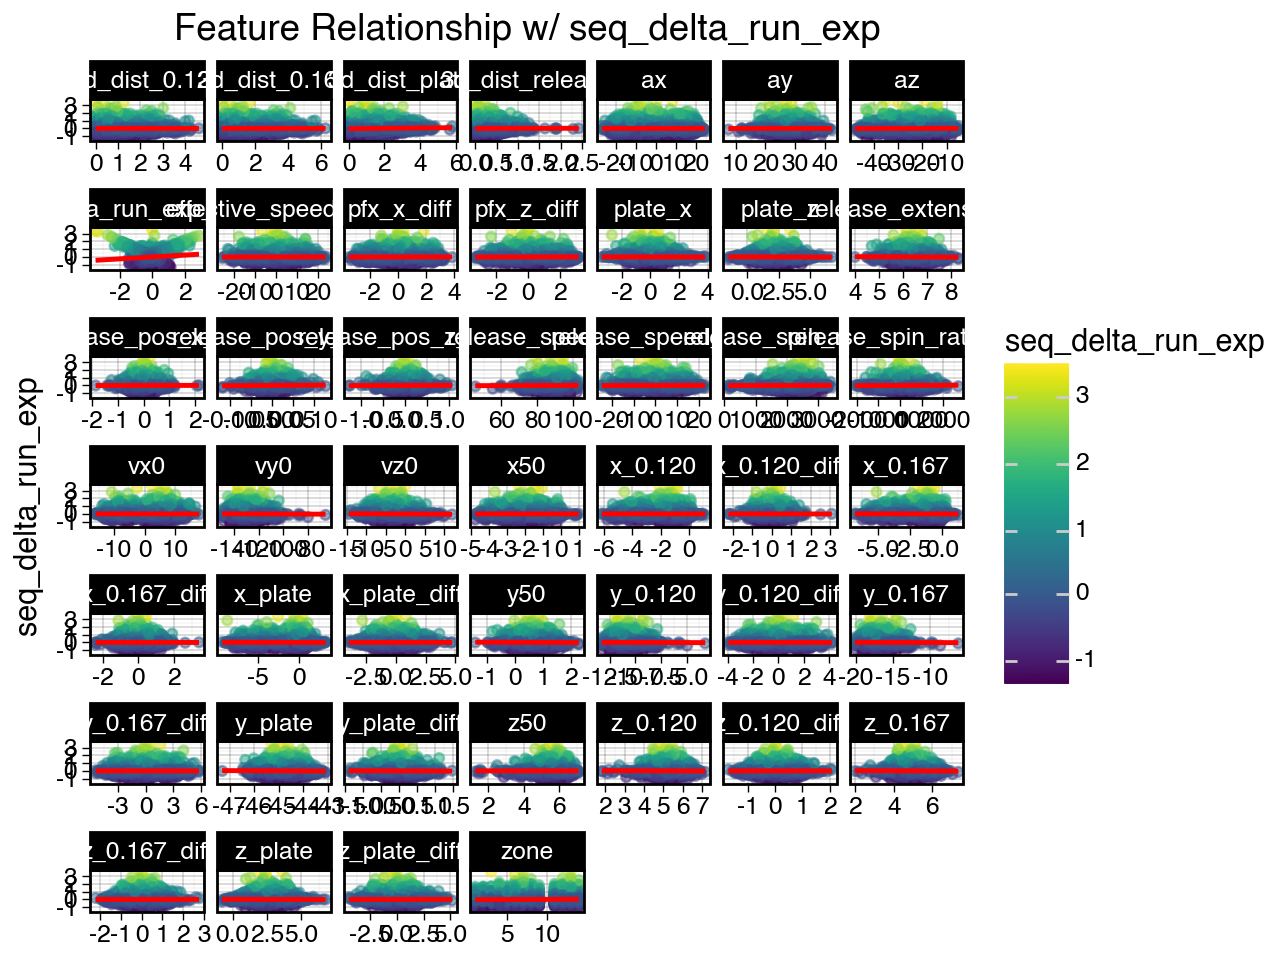

In [20]:
rel_matrix = (
    ggplot(sample_pitches_df.unpivot(index=RESPONSE, on=FEATURES),
           aes(x="value", y="seq_delta_run_exp", color="seq_delta_run_exp"))
    + geom_point(alpha=0.5)
    + geom_smooth(color="red")
    + facet_wrap("~ variable", scales="free_x")
    + theme_linedraw()
    + labs(
        title="Feature Relationship w/ seq_delta_run_exp",
        x="",
    )
)

rel_matrix.show()

### Correlation Matrix

Each chunk represents the pearson correlation coefficient between two features

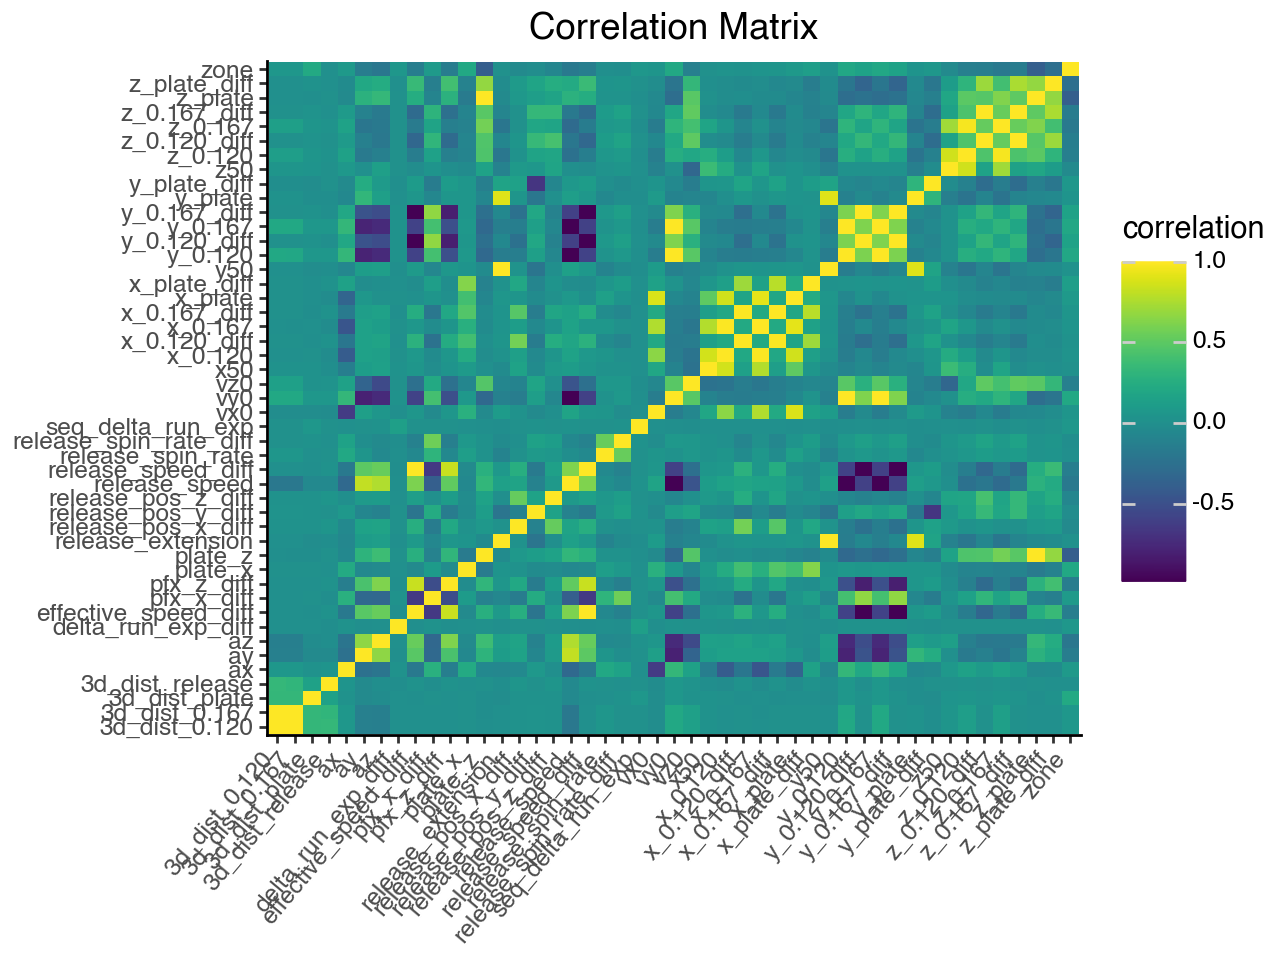

In [21]:
sample_corr_df = sample_pitches_df.corr()

corr_matrix = (
    ggplot(
        sample_corr_df
        .with_columns(pl.Series("variable_1", sample_corr_df.columns))
        .unpivot(
            index="variable_1",
            variable_name="variable_2",
            on=sample_corr_df.columns,
            value_name="correlation",
        ),
        aes(x="variable_1", y="variable_2", fill="correlation"),
    )
    + geom_tile(size=3)
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=50, hjust=1))
    + labs(
        title="Correlation Matrix",
        x="",
        y="",
    )
)

corr_matrix.show()

### Recursive Feature Selection

In [26]:
estimator = LGBMRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

rfecv.fit(X_scaled, y_scaled)

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11283
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11284
[LightGBM] [Info] Total Bins 11284
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM]

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11233
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 45
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11029
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 45
[LightGBM] [Info] Start training from score 0.106475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10774
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 44
[LightGBM] [Info] Start training from score 0.106475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10978
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 44
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10978
[LightGBM] [Info] Number of data points in the trai

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10519
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 43
[LightGBM] [Info] Start training from score 0.106475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10723
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 43
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10264
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10468
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10468
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10468
[LightGBM] [Info] Number of data points in the trai

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10212
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 41
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10213
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 41
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10213
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 41
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10213
[LightGBM] [Info] Number of data points in the trai

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9957
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 40
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9958
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 40
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9958
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 40
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9702
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9703
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9703
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9703
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9702
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9447
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9448
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9448
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9192
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9193
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Total Bins 9193
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9193
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8937
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8938
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8938
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8937
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8682
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8683
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8683
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8682
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8427
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 34
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8428
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 34
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8428
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 34
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8427
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8172
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8173
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8173
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8172
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8173
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7917
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7918
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7918
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7917
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7918
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7663
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7663
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7663
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7407
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7408
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7408
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7408
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7153
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7153
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7153
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6897
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6898
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6897
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6898
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6898
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6642
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6643
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6643
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6642
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6643
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6387
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6388
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6387
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6388
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6132
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6133
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6133
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5877
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5878
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5877
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5878
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5622
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5623
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5622
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5623
[LightGBM] [Info] Number of data points in the train s

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5367
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5368
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5367
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5368
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5368
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4857
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4857
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4602
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4602
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4603
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4603
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4603
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4348
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4348
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4348
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4093
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4093
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3837
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3837
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3838
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3838
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3838
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3582
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3582
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3327
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3327
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3328
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3328
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3328
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3072
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3072
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2817
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score 0.104033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score 0.108486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Number of data points in th

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score 0.106475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score 0.108783


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score 0.106475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score 0.109169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score 0.106475


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score 0.108783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score 0.104033


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score 0.109169


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score 0.108486


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11283
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 46
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11028
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 45
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10773
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 44
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10722
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 43
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10467
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 42
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10212
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 41
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9957
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 40
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9702
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 39
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9447
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 38
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9192
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 37
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8937
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 36
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8682
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 35
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8427
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 34
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8172
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 33
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7917
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 32
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 31
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7407
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 30
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 29
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6897
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 28
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6642
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 27
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6387
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 26
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6132
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 25
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5877
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 24
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5622
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 23
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5367
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 22
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 21
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4857
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 20
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4602
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 19
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 18
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 17
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3837
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 16
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3582
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 15
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3327
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 14
[LightGBM] [Info] Start training from score 0.107389


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3327
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 14
[LightGBM] [Info] Start training from score 0.107389


RFECV(cv=5, estimator=LGBMRegressor(n_jobs=-1, random_state=42), n_jobs=-1,
      scoring='neg_mean_absolute_error')

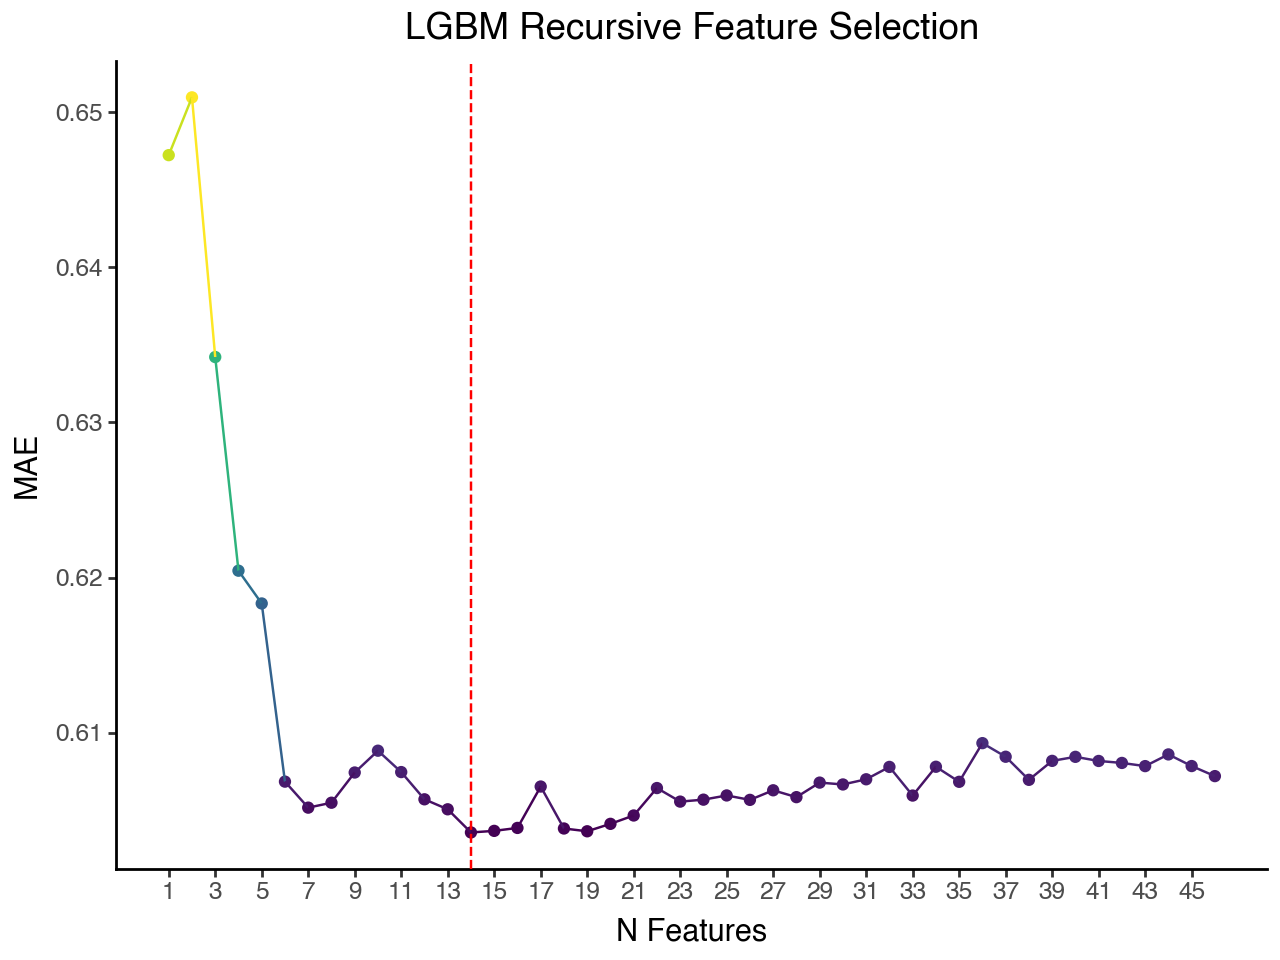

In [27]:
rfecv_plot = (
    ggplot(
        pl.from_dict({
            "N Features": range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
            "MAE": (-rfecv.cv_results_["mean_test_score"]).tolist(),
        }),
        aes(x="N Features", y="MAE", color="MAE"),
    )
    + geom_point()
    + geom_line()
    + geom_vline(xintercept=rfecv.n_features_,
                 color="red",
                 linetype="dashed")
    + theme_classic()
    + scale_x_continuous(breaks=range(1, len(rfecv.cv_results_["mean_test_score"]) + 1, 2))
    + guides(color="none")
    + labs(title="LGBM Recursive Feature Selection")
)

rfecv_plot.show()

In [28]:
rfecv.estimator_.feature_importances_

array([127, 260, 190, 237, 147, 205, 108, 145,  77, 112, 984, 130, 121,
       157], dtype=int32)

In [29]:
selected_feature_mask, *_ = np.where(rfecv.support_)

print("Selected Features")
selected_features = []
for n, i in enumerate(selected_feature_mask):
    f = X.columns[i]
    print(f"{n + 1}: {f}")
    selected_features.append(f)

Selected Features
1: release_speed
2: 3d_dist_release
3: 3d_dist_plate
4: plate_x
5: plate_z
6: z_plate
7: zone
8: y_0.120_diff
9: release_pos_x_diff
10: release_pos_y_diff
11: delta_run_exp_diff
12: x_plate_diff
13: y_plate_diff
14: z_plate_diff
